# (7주차) 10월21일
> Pytorch CNN (MNIST 3,7)

- toc:true
- branch: master
- badges: true
- comments: true
- author: 최규빈

### 강의영상 

> youtube: https://youtube.com/playlist?list=PLQqh36zP38-z7YonYSeq4PyhLt-ab37OJ

`-` (1/2) CNN 모형구축  (MNIST 3,7)

`-` (2/2) 과제설명 

### import 

In [ ]:
!pip install --upgrade fastai

In [2]:
import torch 
from fastai.vision.all import * 

In [3]:
import graphviz

In [4]:
def gv(s): return graphviz.Source('digraph G{ rankdir="LR"'+ s + ';}')

### data 

`-` download data 

In [5]:
path = untar_data(URLs.MNIST_SAMPLE)

In [6]:
path.ls()

(#3) [Path('/root/.fastai/data/mnist_sample/valid'),Path('/root/.fastai/data/mnist_sample/train'),Path('/root/.fastai/data/mnist_sample/labels.csv')]

`-` list 

In [7]:
threes=(path/'train'/'3').ls()
sevens=(path/'train'/'7').ls()

`-` list $\to$ image 

In [8]:
Image.open(threes[4])

`-` image $\to$ tensor 

In [9]:
tensor(Image.open(threes[4]))

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   6,  80, 194, 124,   7,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

- 여기에서 tensor는 파이토치가 아니라 fastai에서 구현한 함수임 

`-` 여러개의 리스트를 모두 텐서로 바꿔보자. 

In [10]:
seven_tensor = torch.stack([tensor(Image.open(i)) for i in sevens]).float()/255
three_tensor = torch.stack([tensor(Image.open(i)) for i in threes]).float()/255

`-` $X$와 $y$를 만들자. 

In [11]:
seven_tensor.shape, three_tensor.shape

(torch.Size([6265, 28, 28]), torch.Size([6131, 28, 28]))

In [12]:
y=torch.tensor([0.0]*6265+ [1.0]*6131).reshape(12396,1)

In [13]:
X=torch.vstack([seven_tensor,three_tensor]).reshape(12396,-1)

In [14]:
X.shape, y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

### 기존의 MLP 모형 

${\bf X} \to {\bf WX+b} \to f({\bf WX+b}) \to \dots \to {\bf y}$
- ${\bf X}=12396 \times 784$ matrix 
- ${\bf y}=12396 \times 1$ (col) vector

`-` 모델을 어떻게 구성할것인가? 
- 아키텍처: 적당히 깊게... + 적당히 넓게... + 표현력이 충분하면서도 + 과적합은 일어나지 않도록.. (저도 잘 몰라요) 
- 손실함수: BCEloss 
- 옵티마이저: Adam 

`-` 교재의 모형 

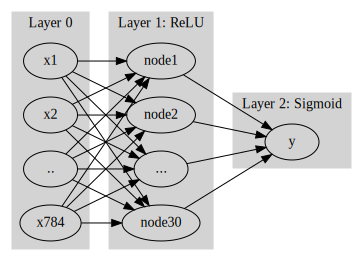

In [15]:
#collapse
gv('''
splines=line
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "x1"
    "x2"
    ".."
    "x784"
    label = "Layer 0"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "x1" -> "node1"
    "x2" -> "node1"
    ".." -> "node1"
    
    "x784" -> "node1"
    "x1" -> "node2"
    "x2" -> "node2"
    ".." -> "node2"
    "x784" -> "node2"
    
    "x1" -> "..."
    "x2" -> "..."
    ".." -> "..."
    "x784" -> "..."

    "x1" -> "node30"
    "x2" -> "node30"
    ".." -> "node30"
    "x784" -> "node30"


    label = "Layer 1: ReLU"
}
subgraph cluster_3{
    style=filled;
    color=lightgrey;
    "node1" -> "y"
    "node2" -> "y"
    "..." -> "y"
    "node30" -> "y"
    label = "Layer 2: Sigmoid"
}
''')

`-` 왜 28$\times$28 이미지를 784개의 벡터로 만든 다음에 모형을 돌려야 하는가? 

`-` 기존에 개발된 모형이 회귀분석 기반으로 되어있어서 결국 회귀분석 틀에 짜 맞추어서 이미지자료를 분석하는 느낌 

`-` observation의 차원은 $784$가 아니라 $1\times (28\times 28)$이 되어야 맞다. 

In [16]:
X.shape

torch.Size([12396, 784])

In [17]:
X=X.reshape(12396,1,28,28)

In [18]:
X.shape

torch.Size([12396, 1, 28, 28])

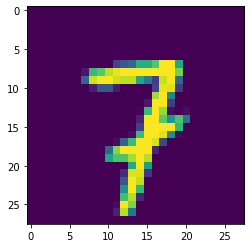

In [19]:
plt.imshow(X[776][0])

### 선형변환 대신에 2d convolution with windowsize=5

In [20]:
c1=torch.nn.Conv2d(1,16,5) # 입력채널=1 (흑백이므로), 출력채널=16, 윈도우크기5 

In [21]:
X.shape, c1(X).shape
# 차원이 변하며 선형변환이다.
# 1개의 28x28 이미지가 16개의 24x24 이미지로 변환됨

(torch.Size([12396, 1, 28, 28]), torch.Size([12396, 16, 24, 24]))

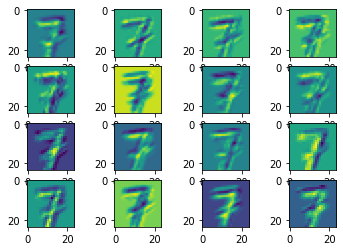

In [22]:
fig, axs = plt.subplots(4,4) 
k=0 
for i in range(4):
    for j in range(4):
        axs[i,j].imshow(c1(X)[776][k].data) 
        k=k+1

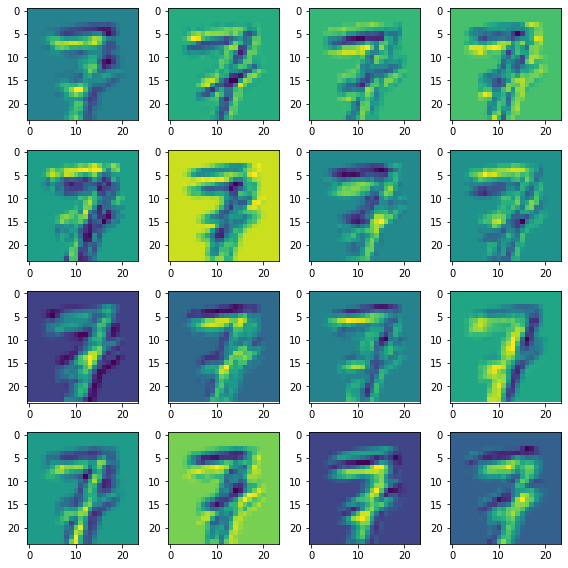

In [23]:
fig.set_figheight(8)
fig.set_figwidth(8)
fig.tight_layout()
fig

### ReLU() 대신 MaxPool2d + ReLU

#### MaxPool2d

In [24]:
m1=torch.nn.MaxPool2d(2)
# 2개의 픽셀을 하나로 압축
# 파라메터를 3으로 바꾸면 3개의 픽셀을 하나로 압축함

In [25]:
X.shape,c1(X).shape,m1(c1(X)).shape

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


(torch.Size([12396, 1, 28, 28]),
 torch.Size([12396, 16, 24, 24]),
 torch.Size([12396, 16, 12, 12]))

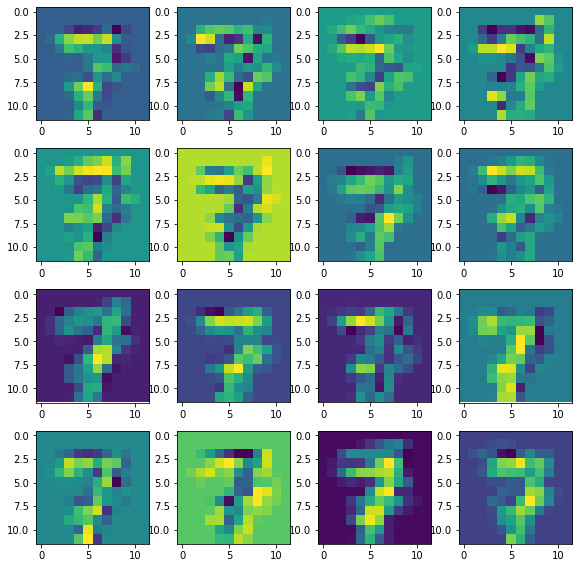

In [26]:
fig, axs = plt.subplots(4,4) 
k=0 
for i in range(4):
    for j in range(4):
        axs[i,j].imshow(m1(c1(X))[776][k].data) 
        k=k+1
fig.set_figheight(8)
fig.set_figwidth(8)
fig.tight_layout()    

- 해상도를 낮추는 효과가 있다.

#### ReLU 

In [27]:
a1=torch.nn.ReLU()

In [28]:
X.shape,c1(X).shape, m1(c1(X)).shape, a1(m1(c1(X))).shape
# 순서대로 원래 데이터, 2d convolution, Maxpool2d, Relu 를 취한 차원

(torch.Size([12396, 1, 28, 28]),
 torch.Size([12396, 16, 24, 24]),
 torch.Size([12396, 16, 12, 12]),
 torch.Size([12396, 16, 12, 12]))

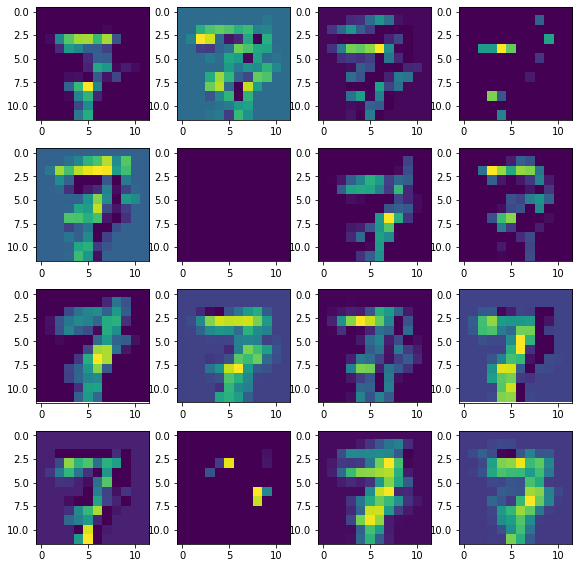

In [29]:
fig, axs = plt.subplots(4,4) 
k=0 
for i in range(4):
    for j in range(4):
        axs[i,j].imshow(a1(m1(c1(X)))[776][k].data) 
        k=k+1
fig.set_figheight(8)
fig.set_figwidth(8)
fig.tight_layout()    

In [30]:
torch.manual_seed(1)
_A= torch.randn((3,3))
_A

tensor([[ 0.6614,  0.2669,  0.0617],
        [ 0.6213, -0.4519, -0.1661],
        [-1.5228,  0.3817, -1.0276]])

In [31]:
a1(_A)

tensor([[0.6614, 0.2669, 0.0617],
        [0.6213, 0.0000, 0.0000],
        [0.0000, 0.3817, 0.0000]])

### 여기에서 그냥 시그모이드에 태우자. 

`-` 현재상황 

In [32]:
a1(m1(c1(X))).shape

torch.Size([12396, 16, 12, 12])

`-` 펼치자

In [33]:
a1(m1(c1(X))).reshape(12396,-1).shape
# 16 x 12 x 12 = 2304

torch.Size([12396, 2304])

`-` 2304의 디멘젼을 1로 만들자. 

In [34]:
l1=torch.nn.Linear(in_features=2304,out_features=1) 

In [35]:
l1(a1(m1(c1(X))).reshape(12396,-1))

tensor([[-0.0390],
        [-0.0523],
        [ 0.0533],
        ...,
        [ 0.0016],
        [ 0.0244],
        [-0.0023]], grad_fn=<AddmmBackward>)

`-` 시그모이드를 걸자. 

In [36]:
a2=torch.nn.Sigmoid() 
a2(l1(a1(m1(c1(X))).reshape(12396,-1)))

tensor([[0.4903],
        [0.4869],
        [0.5133],
        ...,
        [0.5004],
        [0.5061],
        [0.4994]], grad_fn=<SigmoidBackward>)

### networks 설계 

In [ ]:
net = nn.Sequential(
    c1, # 컨볼루션(선형)
    m1, # 맥스풀링(비선형) -- 효과? 이미지를 계층적으로 파악할 수 있게함 
    a1, # 렐루(비선형) 
    
    a1(m1(c1(X))).reshape(12396,-1), ## 이걸 구현해야하는데?? 
    
    l1) 
## 마지막의 a2는 생략한다. torch.nn..BCEWithLogitsLoss()에 내장되어 있을것이므로 

In [ ]:
net = nn.Sequential(
    c1, # 컨볼루션(선형)
    m1, # 맥스풀링(비선형) -- 효과? 이미지를 계층적으로 파악할 수 있게함 
    a1, # 렐루(비선형) 
    
#    a1(m1(c1(X))).reshape(12396,-1), ## 이걸 구현해야하는데?? 
    
    l1) 
## 마지막의 a2는 생략한다. torch.nn..BCEWithLogitsLoss()에 내장되어 있을것이므로 


`-` 결국 주석처리한 부분을 구현해야함. 

`-` `c1`,`m1`,`a1`,`l1`의 공통점 

- 무언가를 상속받는 클래스에서 생성된 인스턴스이다. 
- forward메소드가 있다. 

`-` custom layer를 만드는 방법 
- torch.nn.Module을 상속받아서 클래스를 하나 만든다. 
- forward 메소드를 정의한다. (다음레이어로 리턴할 값)

In [38]:
class Flatten(torch.nn.Module):
    def forward(self,x): 
        return x.reshape(12396,-1)

In [39]:
flatten=Flatten()

In [40]:
flatten(a1(m1(c1(X)))).shape

torch.Size([12396, 2304])

`-` 잘 구현이 된것 같다. 

In [41]:
net = nn.Sequential(
    c1, # 컨볼루션(선형)
    m1, # 맥스풀링(비선형) -- 효과? 이미지를 계층적으로 파악할 수 있게함 
    a1, # 렐루(비선형) 
    flatten,#    a1(m1(c1(X))).reshape(12396,-1), ## 이걸 구현해야하는데?? 
    l1) 
## 마지막의 a2는 생략한다. torch.nn..BCEWithLogitsLoss()에 내장되어 있을것이므로 

`-` 손실함수와 옵티마이저 정의 

In [42]:
loss_fn=torch.nn.BCEWithLogitsLoss()
optimizer= torch.optim.Adam(net.parameters())

`-` step1~4

In [43]:
for epoc in range(200): 
    ## 1 
    yhat=net(X)
    ## 2 
    loss=loss_fn(yhat,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizer.step()
    net.zero_grad()

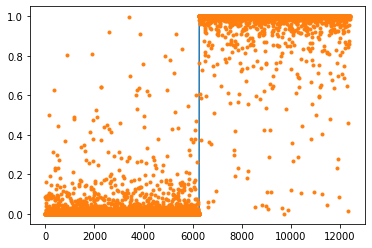

In [44]:
plt.plot(y)
plt.plot(a2(yhat.data),'.')

In [45]:
ypred=a2(yhat.data)>0.5 

In [46]:
sum(ypred==y)/12396

tensor([0.9943])

`-` 좀 더 성능이 좋아졌다. (이미 좋았는데 약간 더 좋아짐) 

### 숙제 

`-` torch.nn.MaxPool2d(2) 대신 torch.nn.MaxPool2d(3) 을 사용하여 모형을 학습해보고 결과비교